In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras

In [ ]:
df = pd.read_csv("cleaned_tweets.csv")
df.dropna(inplace=True)

In [ ]:
df

,Tweet,Label
0,little throwback favourite person water wall,0
1,glam yesterday kcon makeup featherette,7
2,democracy plaza wake stunning outcome decision...,11
3,amp vilo walt disney magic kingdom,0
4,galaxy far far away,2
...,...,...
49995,ootd love chain new ring putaringonit odesigne...,1
49996,met santa olaf north pole today north pole...,0
49997,new york night strideby herelocationnyc seemyc...,11
49998,kiss birthday girl helzberg diamond,0


In [ ]:
X = df["Tweet"].values
y = df["Label"].values

In [ ]:
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(random_state=42)
X = X.reshape(-1,1)
X, y = os.fit_resample(X, y)

In [ ]:
X = X.reshape(-1,)
X.shape


(215140,)

In [ ]:
X

array(['little throwback favourite person   water wall',
       'glam   yesterday kcon makeup   featherette',
       'democracy plaza wake stunning outcome decision   nbc news', ...,
       'cute americasnexttopmodel luckstrikesnyc bepatientandwaitonit justdonatetosay   lucky',
       'story life boymom momlife mysnuggieissoiled',
       'work today love snow theweatherman americanninjawarrior   city norwalk'],
      dtype=object)

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=80000)
tokenizer.fit_on_texts(X)

In [ ]:
print("Text \n",X[:10],'\n')

X_seqs = tokenizer.texts_to_sequences(X)
print("Sequences")
X_seqs[:10]

Text 
 ['little throwback favourite person   water wall'
 'glam   yesterday kcon makeup   featherette'
 'democracy plaza wake stunning outcome decision   nbc news'
 'amp vilo   walt disney magic kingdom' '  galaxy far far away'
 'dinner fla tonight   panseared salmon couscous veggie salad yum dinner florida salmon'
 'fav senior game congrats beating west   west salem'
 'got formal best friend   phi mu jsu'
 'cause miss little homies throwback cousinlove   indiana university'
 'birthday kiss   madison wisconsin'] 

Sequences


[[25, 328, 1673, 312, 509, 674],
 [2794, 191, 23386, 525, 23387],
 [6998, 539, 936, 1154, 8457, 2258, 5308, 1394],
 [6, 43157, 399, 57, 130, 240],
 [2405, 606, 606, 422],
 [141, 14841, 36, 43158, 2425, 43159, 3955, 1494, 1618, 141, 43, 2425],
 [373, 334, 97, 413, 4782, 137, 137, 2406],
 [18, 947, 19, 22, 876, 2606, 26955],
 [388, 86, 25, 1513, 328, 7281, 442, 16],
 [28, 564, 527, 696]]

In [ ]:
idx2words = tokenizer.index_word

print("Word Mappings\n")
for i in range(1,10):
    print("Index: ",i, "->",idx2words[i])

Word Mappings

Index:  1 -> love
Index:  2 -> new
Index:  3 -> day
Index:  4 -> nt
Index:  5 -> happy
Index:  6 -> amp
Index:  7 -> beach
Index:  8 -> christmas
Index:  9 -> time


In [ ]:
vocab_size = len(tokenizer.index_word)
print("Vocabulary size :",len(tokenizer.index_word))

Vocabulary size : 54747


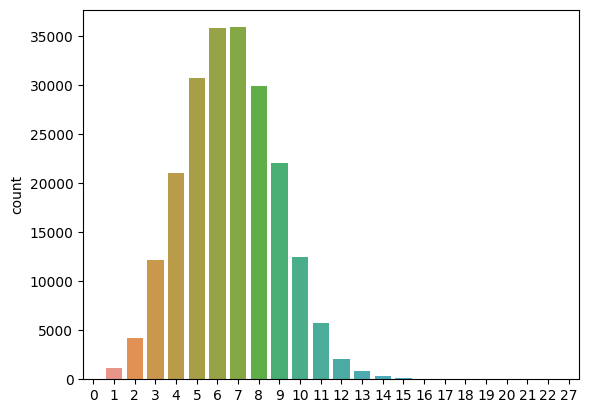

In [ ]:
lens = [len(seq) for seq in X_seqs]
sns.countplot(x=lens)
plt.show()

In [ ]:

from keras.preprocessing.sequence import pad_sequences

max_len=40
X_seqs_pd = pad_sequences(X_seqs, truncating="pre", padding="pre", maxlen=max_len)

In [ ]:
print("Before Padding")
print(X_seqs[:1])

print("\nAfter Padding")
print(X_seqs_pd[:1])

Before Padding
[[25, 328, 1673, 312, 509, 674]]

After Padding
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   25  328 1673  312  509  674]]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test ,y_train, y_test = train_test_split(X_seqs_pd, y, test_size=0.3, random_state=105)
print("Training X Dim ",X_train.shape)
print("Training y Dim ",y_train.shape)

print("Test X Dim ",X_test.shape)
print("Test y Dim ",y_test.shape)

Training X Dim  (150598, 40)
Training y Dim  (150598,)
Test X Dim  (64542, 40)
Test y Dim  (64542,)


In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM, Bidirectional,Embedding, GlobalMaxPool1D



vocabulary_size = vocab_size
seq_len = 40
embed_len=128


model = Sequential()
model.add(Embedding(vocabulary_size+1, embed_len, input_length=seq_len))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           7007744   
                                                                 
 bidirectional (Bidirection  (None, 40, 160)           133760    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40, 160)           154240    
 onal)                                                           
                                                                 
 global_max_pooling1d (Glob  (None, 160)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                        

In [ ]:
from keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=1,verbose=1)

model.compile(loss = 'categorical_crossentropy',
             optimizer = "adam",
             metrics=["accuracy"])

In [ ]:
batch_size=128
epochs = 15

model.fit(X_train, y_train_cat, batch_size=batch_size, epochs = epochs,
          shuffle=True, validation_data=(X_test, y_test_cat), callbacks=[early_stop])

Epoch 1/15
1177/1177 [==============================] - 635s 530ms/step - loss: 2.4068 - accuracy: 0.2615 - val_loss: 1.5614 - val_accuracy: 0.5346
Epoch 2/15
1177/1177 [==============================] - 626s 532ms/step - loss: 1.2233 - accuracy: 0.6440 - val_loss: 0.9433 - val_accuracy: 0.7232
Epoch 3/15
1177/1177 [==============================] - 643s 547ms/step - loss: 0.7567 - accuracy: 0.7816 - val_loss: 0.7292 - val_accuracy: 0.7911
Epoch 4/15
1177/1177 [==============================] - 638s 543ms/step - loss: 0.5486 - accuracy: 0.8435 - val_loss: 0.6218 - val_accuracy: 0.8290
Epoch 5/15
1177/1177 [==============================] - 632s 537ms/step - loss: 0.4213 - accuracy: 0.8816 - val_loss: 0.5790 - val_accuracy: 0.8507
Epoch 6/15
1177/1177 [==============================] - 643s 547ms/step - loss: 0.3399 - accuracy: 0.9050 - val_loss: 0.5620 - val_accuracy: 0.8621
Epoch 7/15
1177/1177 [==============================] - 637s 541ms/step - loss: 0.2908 - accuracy: 0.9192 - val_

In [ ]:
batch_size=128
model.evaluate(X_test, y_test_cat, batch_size=batch_size)

505/505 [==============================] - 68s 134ms/step - loss: 0.5394 - accuracy: 0.8813


[0.5393697619438171, 0.8813331127166748]

In [ ]:
loss = pd.DataFrame(model.history.history)
loss

""


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# predictions = model.predict_classes(X_test)
# print(classification_report(y_test_cat, predictions))
predicted_probabilities = model.predict(X_test)

predicted_classes = np.argmax(predicted_probabilities, axis=1)

true_classes = np.argmax(y_test_cat, axis=1)

print(classification_report(true_classes, predicted_classes))

2017/2017 [==============================] - 135s 66ms/step
              precision    recall  f1-score   support

           0       0.55      0.22      0.32      3210
           1       0.76      0.63      0.69      3238
           2       0.85      0.69      0.76      3269
           3       0.75      0.84      0.79      3240
           4       0.91      0.92      0.91      3197
           5       0.87      0.86      0.87      3247
           6       0.91      0.92      0.91      3251
           7       0.87      0.93      0.90      3108
           8       0.85      0.95      0.90      3226
           9       0.88      0.92      0.90      3185
          10       0.95      0.97      0.96      3221
          11       0.94      0.96      0.95      3262
          12       0.94      0.97      0.96      3244
          13       0.83      0.98      0.90      3188
          14       0.92      0.98      0.95      3335
          15       0.88      0.98      0.93      3249
          16       0.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_classes, predicted_classes)


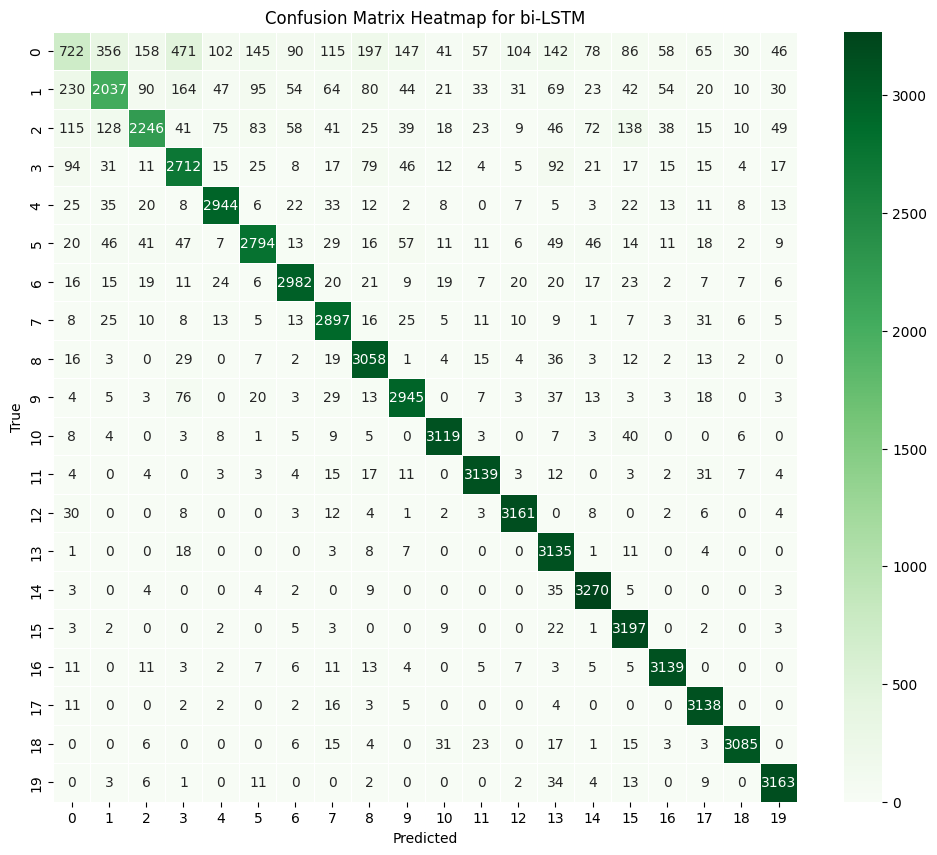

In [ ]:
# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", linewidths=0.5)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap for bi-LSTM')
plt.show()

In [ ]:
model.save("emojiPred_bilstmModel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
emoji_raw = open('us_mapping.txt','r',encoding="utf8")

emojis=[]
for sentence in emoji_raw:
    sentence = sentence.rstrip()
    emojis.append(sentence)


emoji_dict={}

for e in emojis:
    idx = int(e.split()[0])
    emoji = e.split()[1]
    emoji_dict[idx] = emoji

In [ ]:
import string
import re

from tensorflow import keras
emoji_predict_model = keras.models.load_model("emojiPred_bilstmModel.h5", compile=False)


def tweet_clean(tweet):
    tweet = str(tweet).lower()
    rm_mention = re.sub(r'@[A-Za-z0-9]+', '', tweet)
    rm_rt = re.sub(r'RT[/s]+', '', rm_mention)
    rm_links = re.sub(r'http\S+', '', rm_rt)
    rm_links = re.sub(r'https?:\/\/\S+','', rm_links)
    rm_nums = re.sub('[0-9]+', '', rm_links)
    rm_punc = [char for char in rm_nums if char not in string.punctuation]
    rm_punc = ''.join(rm_punc)
    cleaned = rm_punc

    return cleaned


# def predict_emoji(text, model=emoji_predict_model):
#     text = tweet_clean(text)
#     X_sequences = text
#     predictions = np.argmax(model.predict(X_sequences), axis=1)
#     emoji_idx = predictions[0]
#     emoji = emoji_dict[emoji_idx]

#     return emoji

def predict_emoji(text, model=emoji_predict_model):
    text = tweet_clean(text)

    # Tokenize and pad the text
    max_len = 40
    tokenizer = Tokenizer(num_words=20)
    tokenizer.fit_on_texts([text])
    text_sequence = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_sequence, truncating="pre", padding="pre", maxlen=max_len)

    # Make predictions
    predictions = np.argmax(model.predict(text_padded), axis=1)
    emoji_idx = predictions[0]
    emoji = emoji_dict.get(emoji_idx, "Unknown")

    return emoji


In [ ]:
text = input("Enter tweet \n")

print("\nEmojified Tweet \n")
print(text+" "+predict_emoji(text))

Enter tweet 
Winter is coming

Emojified Tweet 

1/1 [==============================] - 0s 71ms/step
Winter is coming 💕
